# Band Ratio Caculations

In [21]:
# import libraries
import rasterio
from rasterio.plot import show
import rasterio.mask
import fiona
import numpy as np
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt
import geopandas

## Define import function

In [3]:
def import_image(filepath):
    
    with rasterio.open(filepath) as src:
        img = src.read()
        img_profile = src.profile
       
    return img, img_profile

## Set Paths to image and mask rasters

In [4]:
# Set paths
image_path = r'C:\Users\user\Desktop\COGS\Major project\Images\Sentinal Images\BlackLake.tif'
mask_path = r'C:\Users\user\Desktop\COGS\Major project\Images\Thresholds\1stdevthreshold.tif'

## Import Rasters

In [5]:
image_ds, img_profile = import_image(image_path)
mask_ds, mask_profile = import_image(mask_path)

In [6]:
# check info of arrays - this will tell you width, height, and depth of the raster array
print(image_ds.shape)
print(img_profile)
print(mask_ds.shape)
print(mask_profile)

(11, 4159, 7599)
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7599, 'height': 4159, 'count': 11, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 471840.0,
       0.0, -10.0, 6599240.0), 'tiled': False, 'interleave': 'pixel'}
(1, 4159, 7599)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 7599, 'height': 4159, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 471840.0,
       0.0, -10.0, 6599240.0), 'tiled': False, 'interleave': 'band'}


## Assign Bands to Variables

In [47]:
# double and triple check that these are the correct band mappings for gdal
blue = image_ds[1]
green = image_ds[2]
red = image_ds[3]
rededge = image_ds[6]
nir = image_ds[7]
#swir1=image_ds[10]
#swir2=image_ds[11]
vegmask = mask_ds[0]



## Calculate Indecis Surfaces

In [184]:
# after ensuring that the bands are properly mapped, running this cell will calculate the below ratios

#allow disvision by zero
np.seterr(divide='ignore', invalid='ignore')

ndvi = (nir.astype(float) - red.astype(float))/(nir + red)
ndre = (nir.astype(float) - rededge.astype(float))/(nir + rededge)
evi = 2.5 * ((nir.astype(float) - red.astype(float))/(1 + nir + 6*red - 7.5*blue))
#vigs = ((green-red)/(green+red))+0.5*((nir-red)/(nir+red))+1.5*((nir-swir1)/(nir+swir1))+1.5*((nir-swir2)/(nir+swir2))

[[       nan        nan        nan ... 0.0952381  0.16666667 0.1292517 ]
 [       nan        nan        nan ... 0.27027027 0.         0.19125683]
 [       nan        nan        nan ... 0.53948462 0.43933054 0.14606742]
 ...
 [       nan        nan        nan ... 0.66161027 0.6742029  0.69420035]
 [       nan        nan        nan ... 0.67181246 0.68728121 0.69336384]
 [       nan        nan        nan ... 0.67040359 0.67912593 0.6938899 ]]
[[        nan         nan         nan ... -0.47428571 -0.50877193
  -0.05681818]
 [        nan         nan         nan ...  0.120954   -0.50437318
   0.07920792]
 [        nan         nan         nan ...  0.07925408 -0.39329806
  -0.37804878]
 ...
 [        nan         nan         nan ...  0.03151032  0.03847537
   0.03138374]
 [        nan         nan         nan ...  0.04465881  0.03916637
   0.04298802]
 [        nan         nan         nan ...  0.05974395  0.0496046
   0.05980318]]
nan
nan


## Mask Indecis surfaces with the Vegation Mask

In [49]:
# mask these out by simply multiplying by the raster mask
ndvi_veg = ndvi * vegmask
ndre_veg =ndre * vegmask
evi_veg =evi * vegmask
#vigs_veg =vigs * vegmask


(4159, 7599)

## Export Indecis as rasters

In [55]:
#Export Vegation Masked NDVI as raster
with rasterio.open('vegmasked_ndvi.tif', 'w', **mask_profile) as dst:
    dst.write(ndvi_veg.astype(rasterio.float32),1)

#Export Vegation Masked NDRE as raster
with rasterio.open('vegmasked_ndre.tif', 'w', **mask_profile) as dst:
    dst.write(ndre_veg.astype(rasterio.float32),1)
    
#Export Vegation Masked EVI as raster
with rasterio.open('vegmasked_evi.tif', 'w', **mask_profile) as dst:
    dst.write(evi_veg.astype(rasterio.float32),1)
   
#Export Vegation Masked VIGS as raster    
#with rasterio.open('vegmasked_vigs.tif', 'w', **mask_profile) as dst:
#    dst.write(vigs_veg.astype(rasterio.float32),1)

## Clip out the Uranium areas 

NDVI

In [118]:
#open uranium area shapfile with fiona
with fiona.open(r'C:\Users\user\Desktop\COGS\Major project\Images\shapes\ubff_reprojected.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

 #ndvi in unraniun areas   
with rasterio.open("vegmasked_ndvi.tif") as src:
    ndvi_ubuff, out_transform = rasterio.mask.mask(src,shapes, crop=True)
      
with rasterio.open('ndvi_ubuff.tif', 'w', **mask_profile) as dst:
    dst.write(ndvi_ubuff.astype(rasterio.float32))

    
#ndvi outside uranium areas
with rasterio.open("vegmasked_ndvi.tif") as src:
    ndvi_background, out_transform = rasterio.mask.mask(src,shapes, invert=True)
        
with rasterio.open('ndvi_background.tif', 'w', **mask_profile) as dst:
    dst.write(ndvi_background.astype(rasterio.float32))

NDRE

In [57]:
 #ndre in unraniun areas   
with rasterio.open("vegmasked_ndre.tif") as src:
    ndre_ubuff, out_transform = rasterio.mask.mask(src,shapes, crop=True)
      
with rasterio.open('ndre_ubuff.tif', 'w', **mask_profile) as dst:
    dst.write(ndre_ubuff.astype(rasterio.float32))

#ndre outside uranium areas
with rasterio.open("vegmasked_ndre.tif") as src:
    ndre_background, out_transform = rasterio.mask.mask(src,shapes, invert=True)
        
with rasterio.open('ndre_background.tif', 'w', **mask_profile) as dst:
    dst.write(ndre_background.astype(rasterio.float32))

EVI

In [58]:
 #EVI in unraniun areas   
with rasterio.open("vegmasked_evi.tif") as src:
    evi_ubuff, out_transform = rasterio.mask.mask(src,shapes, crop=True)
      
with rasterio.open('evi_ubuff.tif', 'w', **mask_profile) as dst:
    dst.write(evi_ubuff.astype(rasterio.float32))

#ndre outside uranium areas
with rasterio.open("vegmasked_evi.tif") as src:
    evi_background, out_transform = rasterio.mask.mask(src,shapes, invert=True)
        
with rasterio.open('evi_background.tif', 'w', **mask_profile) as dst:
    dst.write(evi_background.astype(rasterio.float32))

## Read in Rasters as 2 Dimensional Arrays

In [192]:
#NDVI
ndvi_ubuff_array=rasterio.open('ndvi_ubuff.tif')
ndvi_ubuff_array=ndvi_ubuff_array.read(1,masked=True)
ndvi_ubuff_array=np.ma.masked_invalid(ndvi_ubuff_array)

ndvi_background_array=rasterio.open('ndvi_background.tif')
ndvi_background_array=ndvi_background_array.read(1,masked=True)
ndvi_background_array=np.ma.masked_invalid(ndvi_background_array)

#NDRE
ndre_ubuff_array=rasterio.open('ndre_ubuff.tif')
ndre_ubuff_array=ndre_ubuff_array.read(1,masked=True)
ndre_ubuff_array=np.ma.masked_invalid(ndre_ubuff_array)

ndre_background_array=rasterio.open('ndre_background.tif')
ndre_background_array=ndre_background_array.read(1,masked=True)
ndre_background_array=np.ma.masked_invalid(ndre_background_array)

#EVI
evi_ubuff_array=rasterio.open('evi_ubuff.tif')
evi_ubuff_array=evi_ubuff_array.read(1,masked=True)
evi_ubuff_array=np.ma.masked_invalid(evi_ubuff_array)

evi_background_array=rasterio.open('evi_background.tif')
evi_background_array=evi_background_array.read(1,masked=True)
evi_background_array=np.ma.masked_invalid(evi_background_array)

# Plot Arrays against each other

ndvi vs ndre

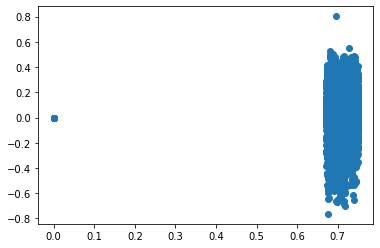

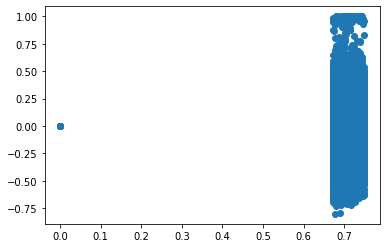

In [205]:
plt.scatter(ndvi_ubuff_array,ndre_ubuff_array)
plt.show()


plt.scatter(ndvi_background_array,ndre_background_array)
plt.show()

ndvi vs evi

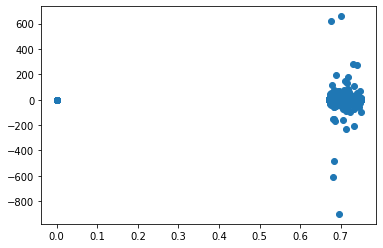

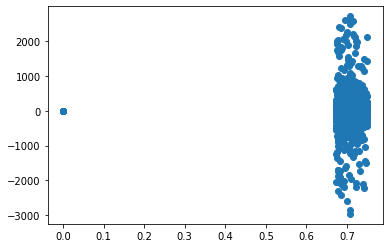

In [171]:
plt.scatter(ndvi_ubuff_array,evi_ubuff_array)
plt.show()


plt.scatter(ndvi_background_array,evi_background_array)
plt.show()

ndre vs evi

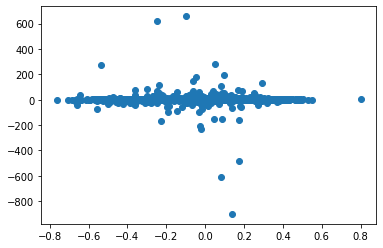

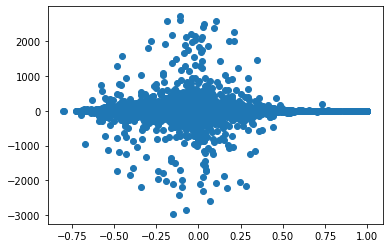

In [173]:
plt.scatter(ndre_ubuff_array,evi_ubuff_array)
plt.show()


plt.scatter(ndre_background_array,evi_background_array)
plt.show()

## Normalize Indecis value between 0 and 1 for comparison and plotting

In [194]:
print(np.min(ndvi_ubuff_array))
print(np.min(ndre_ubuff_array))
print(np.min(evi_ubuff_array))
print(np.min(ndvi_background_array))
print(np.min(ndre_background_array))
print(np.min(evi_background_array))

0.0
-0.76407504
-900.0
0.0
-0.80223465
-2960.0


In [196]:
# normalize the outputs - find a normalizaiton method and use the same
ndvi_ubuff_normal = (ndvi_ubuff_array-np.min(ndvi_ubuff_array))/(np.max(ndvi_ubuff_array)-np.min(ndvi_ubuff_array))
ndre_ubuff_normal = (ndre_ubuff_array-np.min(ndre_ubuff_array))/(np.max(ndre_ubuff_array)-np.min(ndre_ubuff_array))
evi_ubuff_normal = (evi_ubuff_array-np.min(evi_ubuff_array))/(np.max(evi_ubuff_array)-np.min(evi_ubuff_array))
#vigs_ubuff_normal = (vigs_ubuff_array-np.min(vigs_ubuff_array))/(np.max(vigs_ubuff_array)-np.min(vigs_ubuff_array))

ndvi_background_normal = (ndvi_background_array-np.min(ndvi_background_array))/(np.max(ndvi_background_array)-np.min(ndvi_background_array))
ndre_background_normal = (ndre_background_array-np.min(ndre_background_array))/(np.max(ndre_background_array)-np.min(ndre_background_array))
evi_background_normal = (evi_background_array-np.min(evi_background_array))/(np.max(evi_background_array)-np.min(evi_background_array))


In [203]:
print(np.min(ndvi_ubuff_normal),np.max(ndvi_ubuff_normal))
print(np.min(ndre_ubuff_normal),np.max(ndre_ubuff_normal))
print(np.min(evi_ubuff_normal),np.max(evi_ubuff_normal))
print(np.min(ndvi_background_normal),np.max(ndvi_background_normal))
print(np.min(ndre_background_normal),np.max(ndre_background_normal))
print(np.min(evi_background_normal),np.max(evi_background_normal))

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


# Plot Normalized Arrays against each other

## Normal NDVI vs NDRE

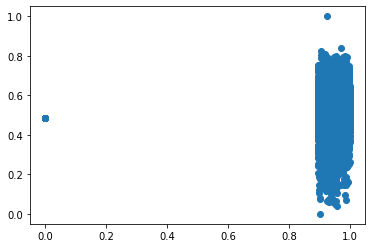

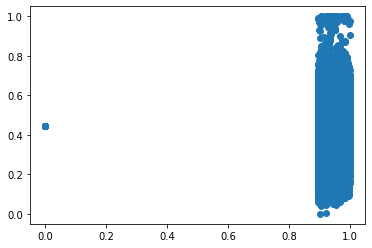

In [198]:
plt.scatter(ndvi_ubuff_normal,ndre_ubuff_normal)
plt.show()

plt.scatter(ndvi_background_normal,ndre_background_normal)
plt.show()

 ## Normal NDVI vs EVI

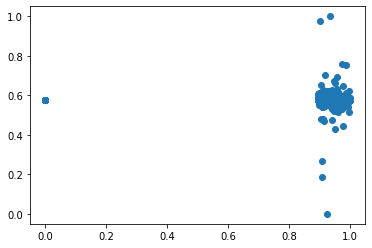

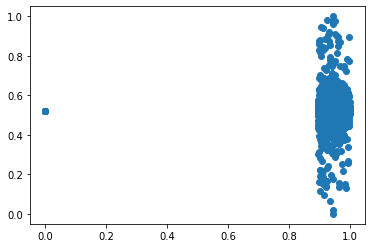

In [199]:
plt.scatter(ndvi_ubuff_normal,evi_ubuff_normal)
plt.show()

plt.scatter(ndvi_background_normal,evi_background_normal)
plt.show()

## NDRE vs EVI

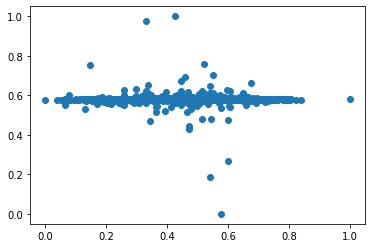

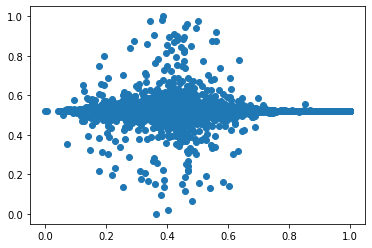

In [200]:
plt.scatter(ndre_ubuff_normal,evi_ubuff_normal)
plt.show()

plt.scatter(ndre_background_normal,evi_background_normal)
plt.show()

In [ ]:
# export the images to inspect